In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import circuit_simulator as cs

In [4]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

Calculating overlap with $|0\rangle$ is linear

In [5]:
%timeit cs.sample_process(5)

4.33 ms ± 423 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
%timeit cs.sample_process(10)

9.88 ms ± 735 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
%timeit cs.sample_process(50)

62.7 ms ± 7.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
%timeit cs.sample_process(100)

117 ms ± 11.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
%timeit cs.sample_process(500)

556 ms ± 74.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
%timeit cs.sample_process(1000)

996 ms ± 12.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Calculating overlap with every part is quadratic (although it is possible to speed it up to $O(n \log n)$)

In [30]:
%timeit len(cs.sample_all_qubits(10))

28.4 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [31]:
%timeit len(cs.sample_all_qubits(20))

105 ms ± 6.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [32]:
%timeit len(cs.sample_all_qubits(40))

364 ms ± 3.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
%timeit len(cs.sample_all_qubits(80))

1.44 s ± 52.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
%timeit len(cs.sample_all_qubits(160))

5.8 s ± 303 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can speed this up to $O(n\log n)$

In [35]:
%timeit len(cs.sample_all_qubits_faster(10))

20.7 ms ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [36]:
%timeit len(cs.sample_all_qubits_faster(20))

48.9 ms ± 2.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [37]:
%timeit len(cs.sample_all_qubits_faster(40))

103 ms ± 1.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [38]:
%timeit len(cs.sample_all_qubits_faster(80))

223 ms ± 4.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
%timeit len(cs.sample_all_qubits_faster(160))

513 ms ± 25.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
%timeit len(cs.sample_all_qubits_faster(320))

1.06 s ± 24.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
%timeit len(cs.sample_all_qubits_faster(640))

2.5 s ± 145 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Verifying against cirq


In [30]:
import cirq

In [31]:
simulator = cirq.Simulator()

In [32]:
n_qubits = 25

In [34]:
l = cs.sample_ladder(n_qubits)

In [35]:
lp = [cirq.ops.matrix_gates.TwoQubitMatrixGate(g)(cirq.LineQubit(p[0]), cirq.LineQubit(p[1])) for p, g in l]

In [36]:
c2 = cirq.Circuit(lp[:(n_qubits - 1)])
c2 = c2 + cirq.inverse(c2[:-1])

In [37]:
%timeit r = simulator.simulate(c2)

29.4 s ± 1.91 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [53]:
r = simulator.simulate(c2)

In [57]:
def benchmark_cirq(n_qubits, r):
    probs = []
    for i in range(n_qubits):
        p = r.density_matrix_of([cirq.LineQubit(i)])[0,0]
        probs.append(p)
    return probs
def benchmark_mps(n_qubits, m):
    probs = get_all_probabilities(m.copy())
    return probs
def benchmark_mps_faster(n_qubits, m):
    probs = get_all_probabilities_faster(m.copy())
    return probs

In [58]:
%timeit benchmark_cirq(n_qubits, r)

10.7 s ± 373 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [59]:
benchmark_cirq(n_qubits, r)

[(0.9844724+0j),
 (0.9907103+0j),
 (0.99052685+0j),
 (0.98383313+0j),
 (0.980944+0j),
 (0.980554+0j),
 (0.98590446+0j),
 (0.9672068+0j),
 (0.97000843+0j),
 (0.9773443+0j),
 (0.9668251+0j),
 (0.9801473+0j),
 (0.986234+0j),
 (0.99157333+0j),
 (0.9343696+0j),
 (0.88767266+0j),
 (0.9007096+0j),
 (0.8533077+0j),
 (0.8919308+0j),
 (0.7577953+0j),
 (0.84725815+0j),
 (0.83867824+0j),
 (0.65847427+0j),
 (0.49283192+0j),
 (0.4122598+0j)]

In [60]:
%timeit m = compute_mps(n_qubits, l)

18.9 ms ± 280 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [61]:
m = compute_mps(n_qubits, l)

In [62]:
%timeit benchmark_mps(n_qubits, m)

133 ms ± 1.98 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [63]:
benchmark_mps(n_qubits, m)

[array(0.99247649),
 array(0.9907248),
 array(0.99054164),
 array(0.9838472),
 array(0.98095772),
 array(0.98056867),
 array(0.98591901),
 array(0.96722198),
 array(0.97002218),
 array(0.97735946),
 array(0.96683936),
 array(0.98016115),
 array(0.98623683),
 array(0.99157549),
 array(0.93440059),
 array(0.88774831),
 array(0.90086954),
 array(0.85365873),
 array(0.89262582),
 array(0.75865042),
 array(0.84935343),
 array(0.84164159),
 array(0.66229167),
 array(0.49440509),
 array(0.41580931)]

In [64]:
%timeit benchmark_mps_faster(n_qubits, m)

41.6 ms ± 1.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [65]:
benchmark_mps_faster(n_qubits, m)

[array(0.99247649),
 array(0.9907248),
 array(0.99054164),
 array(0.9838472),
 array(0.98095772),
 array(0.98056867),
 array(0.98591901),
 array(0.96722198),
 array(0.97002218),
 array(0.97735946),
 array(0.96683936),
 array(0.98016115),
 array(0.98623683),
 array(0.99157549),
 array(0.93440059),
 array(0.88774831),
 array(0.90086954),
 array(0.85365873),
 array(0.89262582),
 array(0.75865042),
 array(0.84935343),
 array(0.84164159),
 array(0.66229167),
 array(0.49440509),
 array(0.41580931)]

# Quick benchmark

In [76]:
ps = []
for x in tqdm(range(2000)):
    ps.append(sample_all_qubits_faster(50))
ps = np.array(ps)

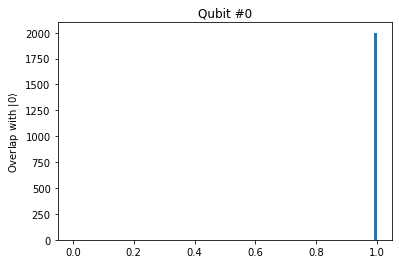

In [96]:
plt.hist(ps[:,0], bins = 100, range=(0,1))
plt.title(f"Qubit #{0}")
plt.ylabel(r"Overlap with $|0\rangle$")
plt.show()

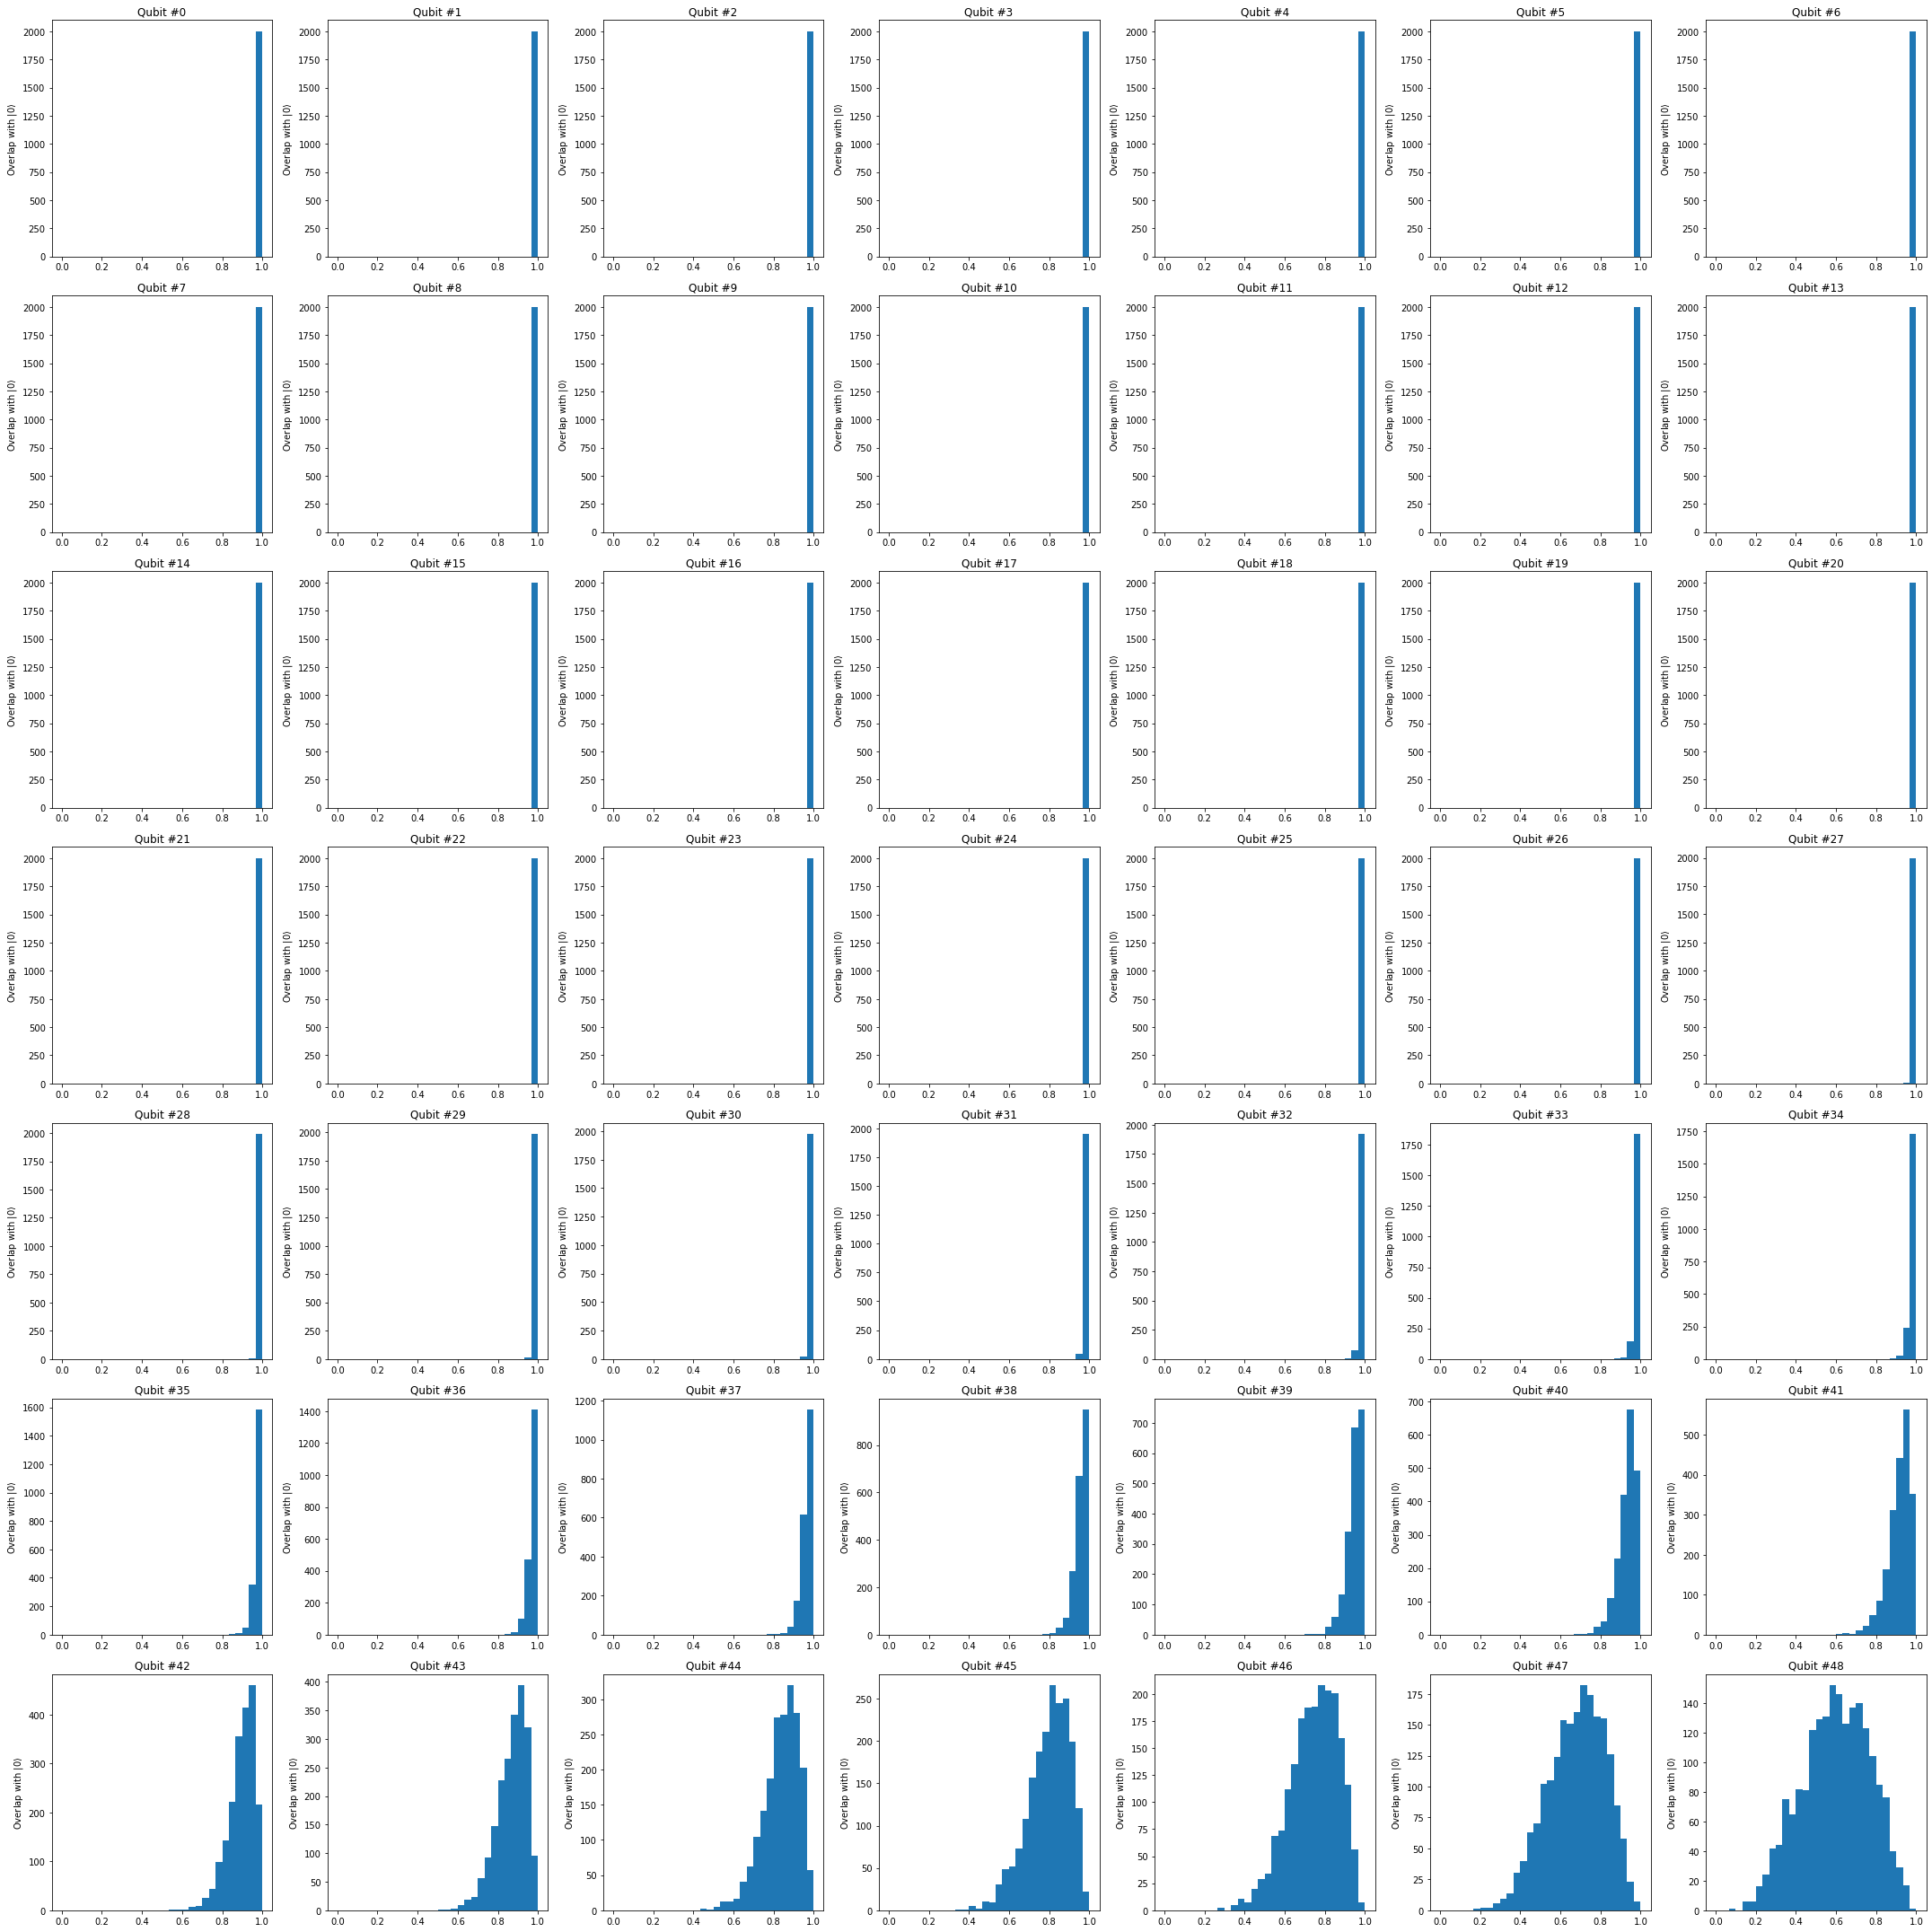

In [100]:
fig=plt.figure(figsize=(30, 30))
t = 0
for i in range(49):
    ax=fig.add_subplot(7,7, i+1)
    ax.hist(ps[:, i], bins = 30, range=(0,1))
    ax.set_title(f"Qubit #{i}")
    ax.set_ylabel(r"Overlap with $|0\rangle$")
fig.tight_layout()  # Improves appearance a bit.
# plt.savefig('concurrences_bigger.png')
plt.show()


In [203]:
top3 = [sample_top_k(30) for i in tqdm(range(1000))]

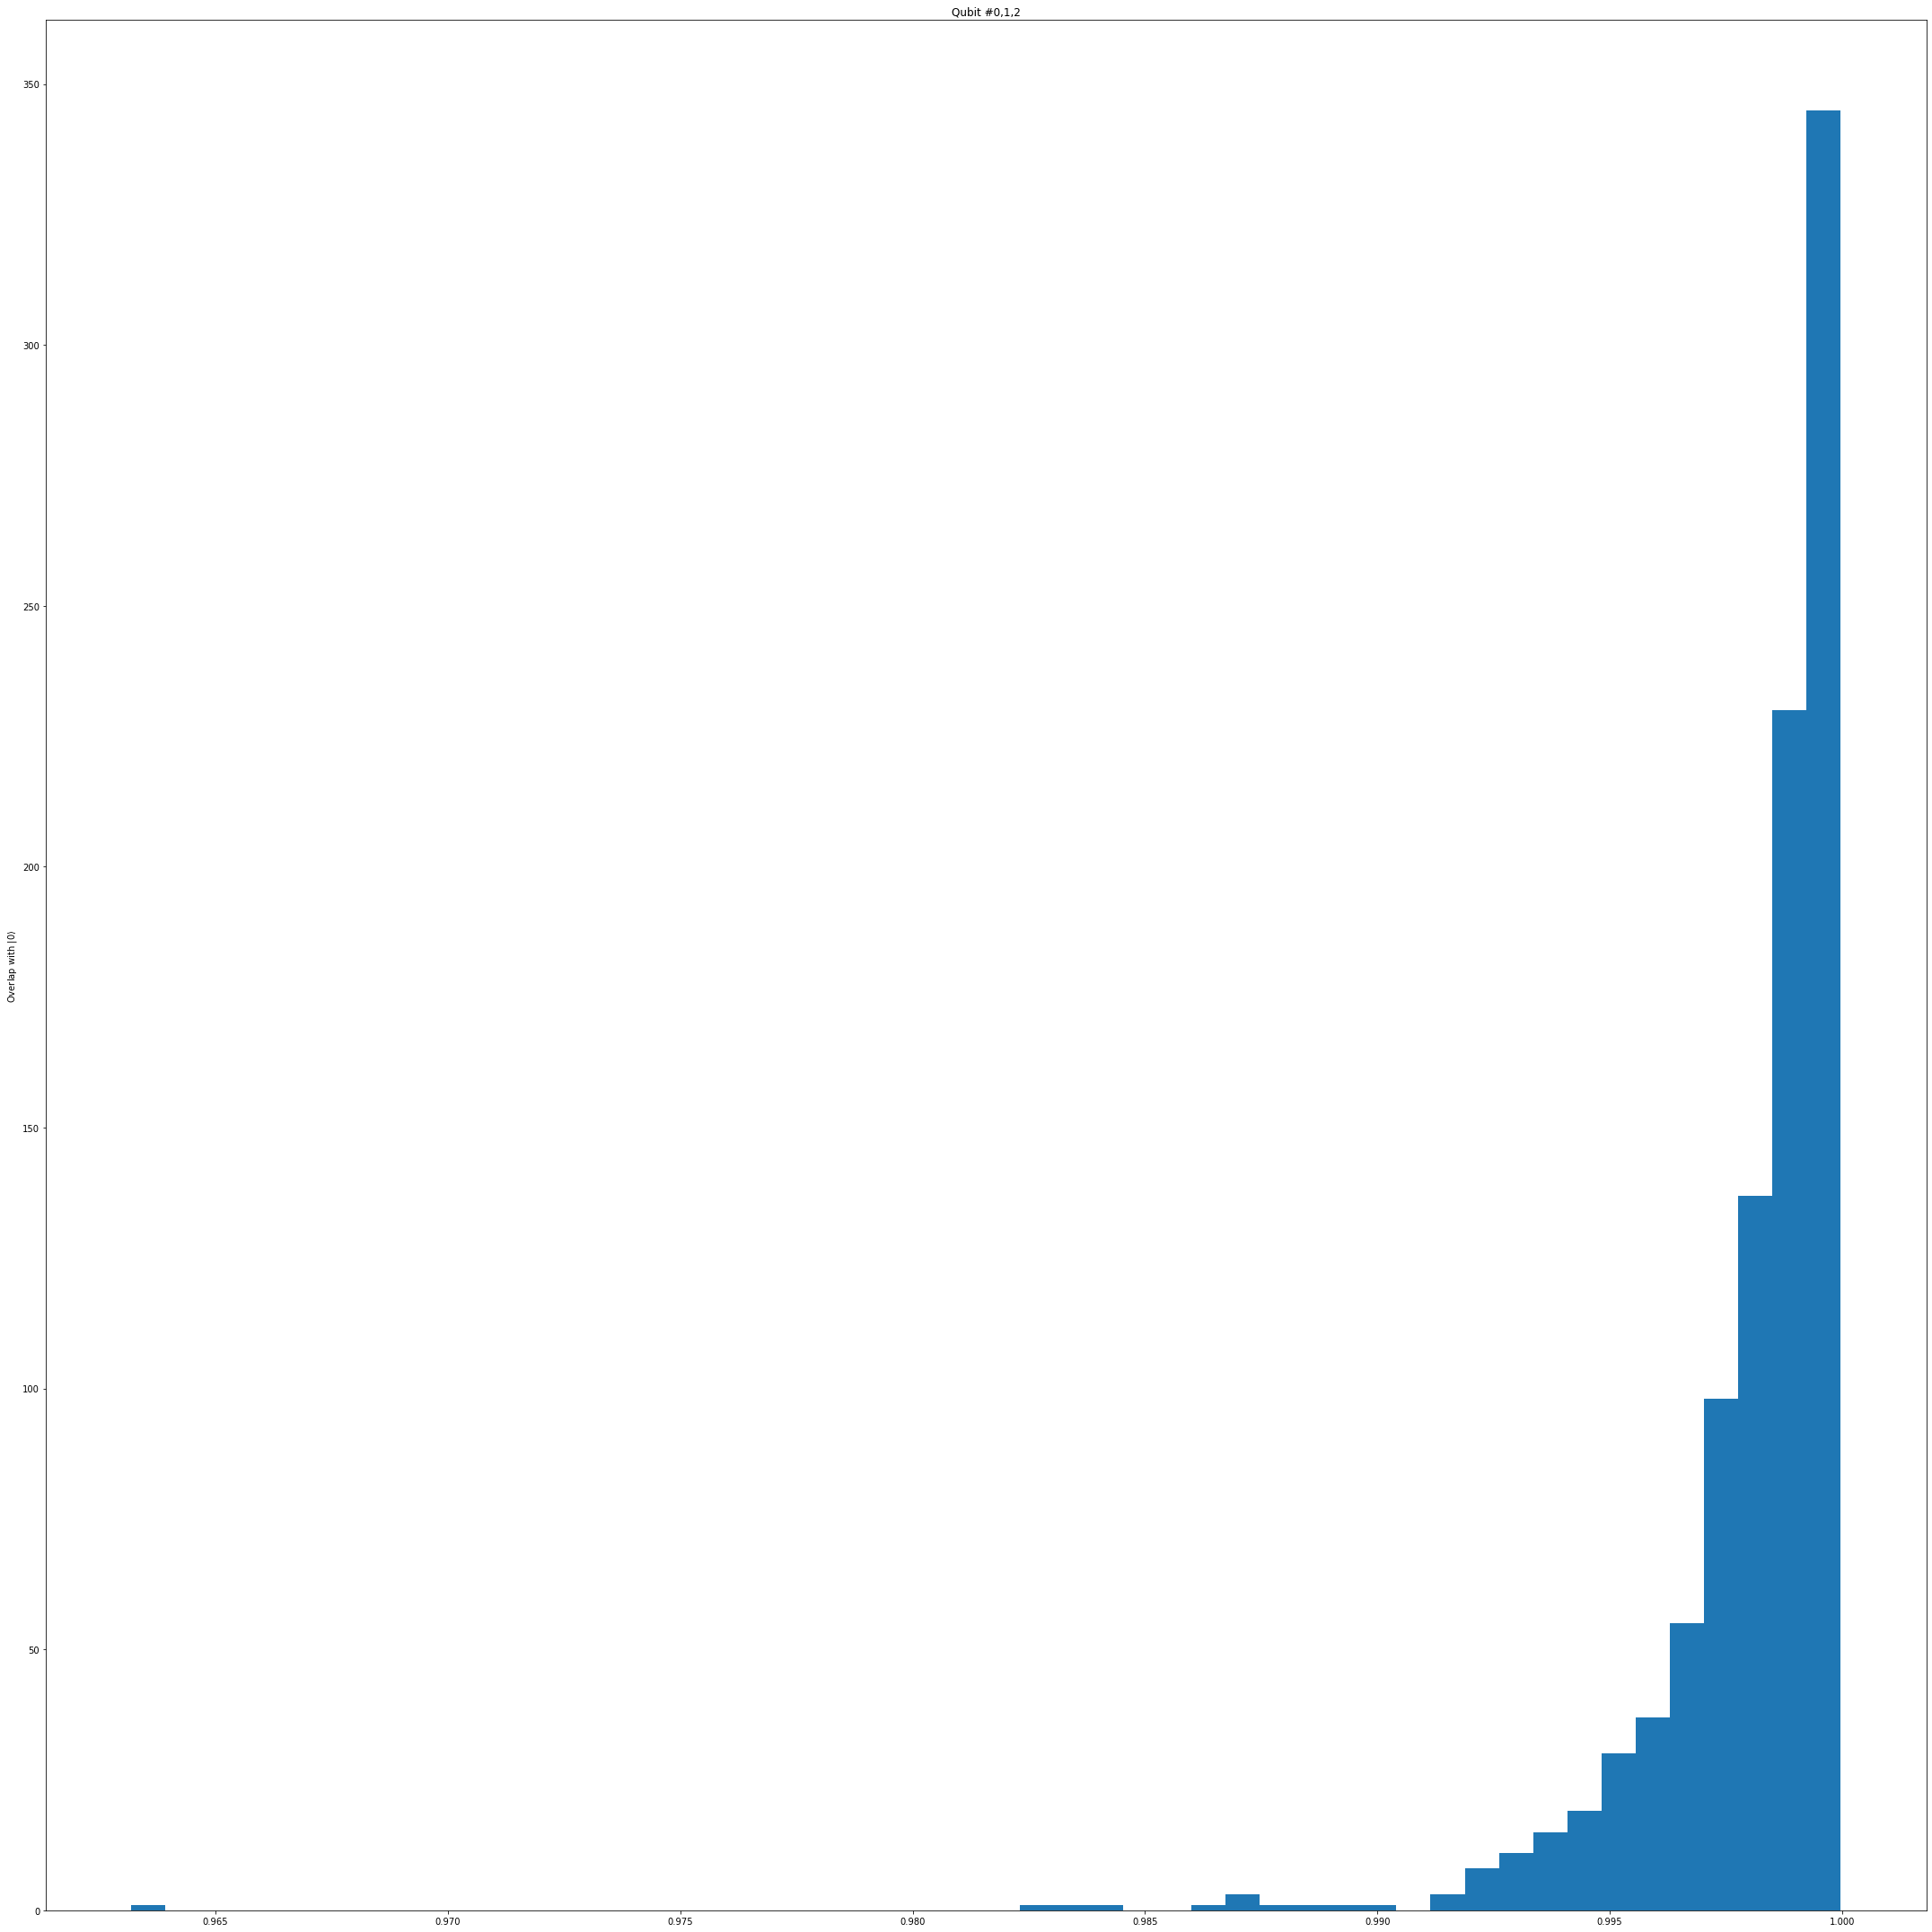

In [206]:
fig=plt.figure(figsize=(30, 30))
t = 0
ax=fig.add_subplot(1,1, 1)
ax.hist(top3, bins = 50)
ax.set_title("Qubit #0,1,2")
ax.set_ylabel(r"Overlap with $|0\rangle$")
fig.tight_layout()  # Improves appearance a bit.
# plt.savefig('concurrences_bigger.png')
plt.show()
# Note the range

# New ladder

In [18]:
ps = []
for x in tqdm(range(200)):
    ps.append(cs.sample_better_ladder_faster_probabilities(4,1))
ps = np.array(ps)

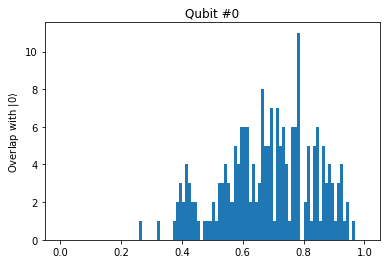

In [19]:
plt.hist(ps[:,0], bins = 100, range=(0,1))
plt.title(f"Qubit #{0}")
plt.ylabel(r"Overlap with $|0\rangle$")
plt.show()

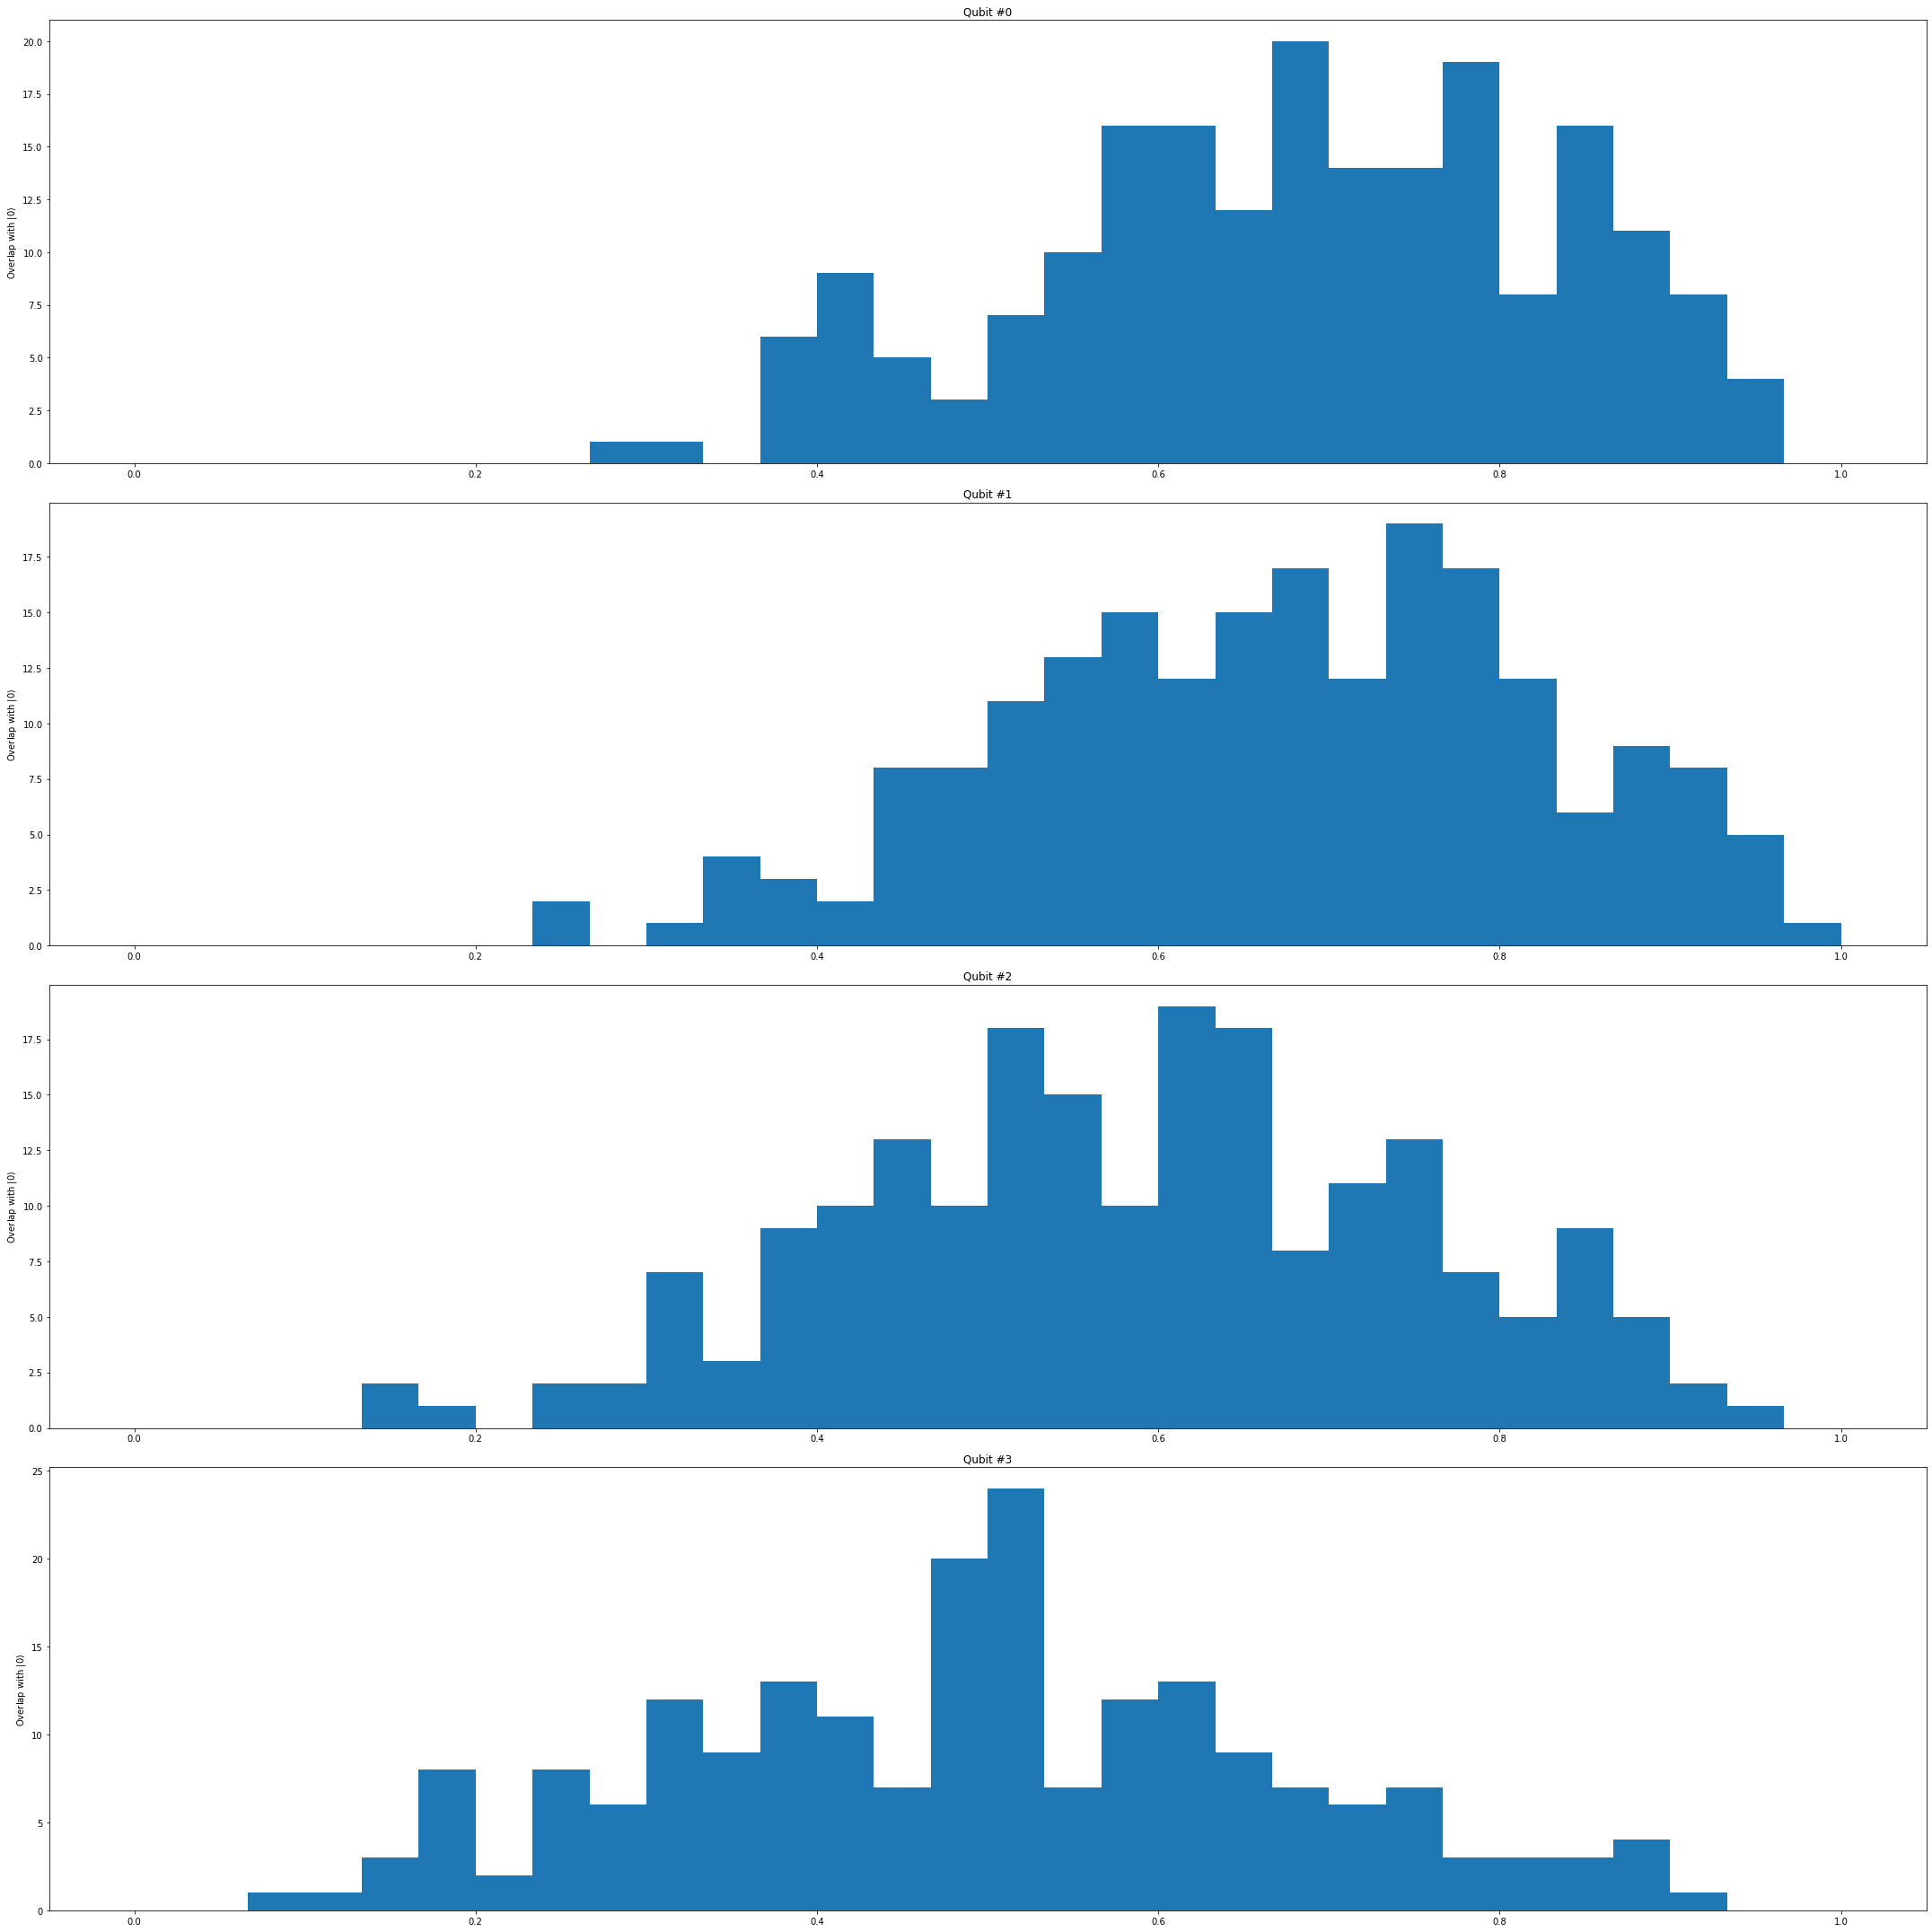

In [21]:
fig=plt.figure(figsize=(30, 30))
t = 0
for i in range(4):
    ax=fig.add_subplot(4,1, i+1)
    ax.hist(ps[:, i], bins = 30, range=(0,1))
    ax.set_title(f"Qubit #{i}")
    ax.set_ylabel(r"Overlap with $|0\rangle$")
fig.tight_layout()  # Improves appearance a bit.
# plt.savefig('concurrences_bigger.png')
plt.show()


In [26]:
ps = []
for x in tqdm(range(200)):
    ps.append(cs.sample_better_ladder_faster_probabilities(3*3+1,2))
ps = np.array(ps)

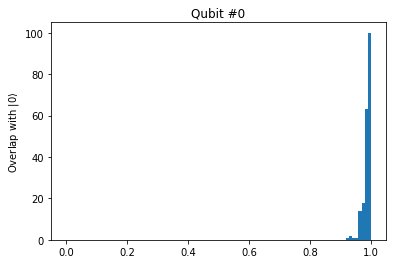

In [27]:
plt.hist(ps[:,0], bins = 100, range=(0,1))
plt.title(f"Qubit #{0}")
plt.ylabel(r"Overlap with $|0\rangle$")
plt.show()

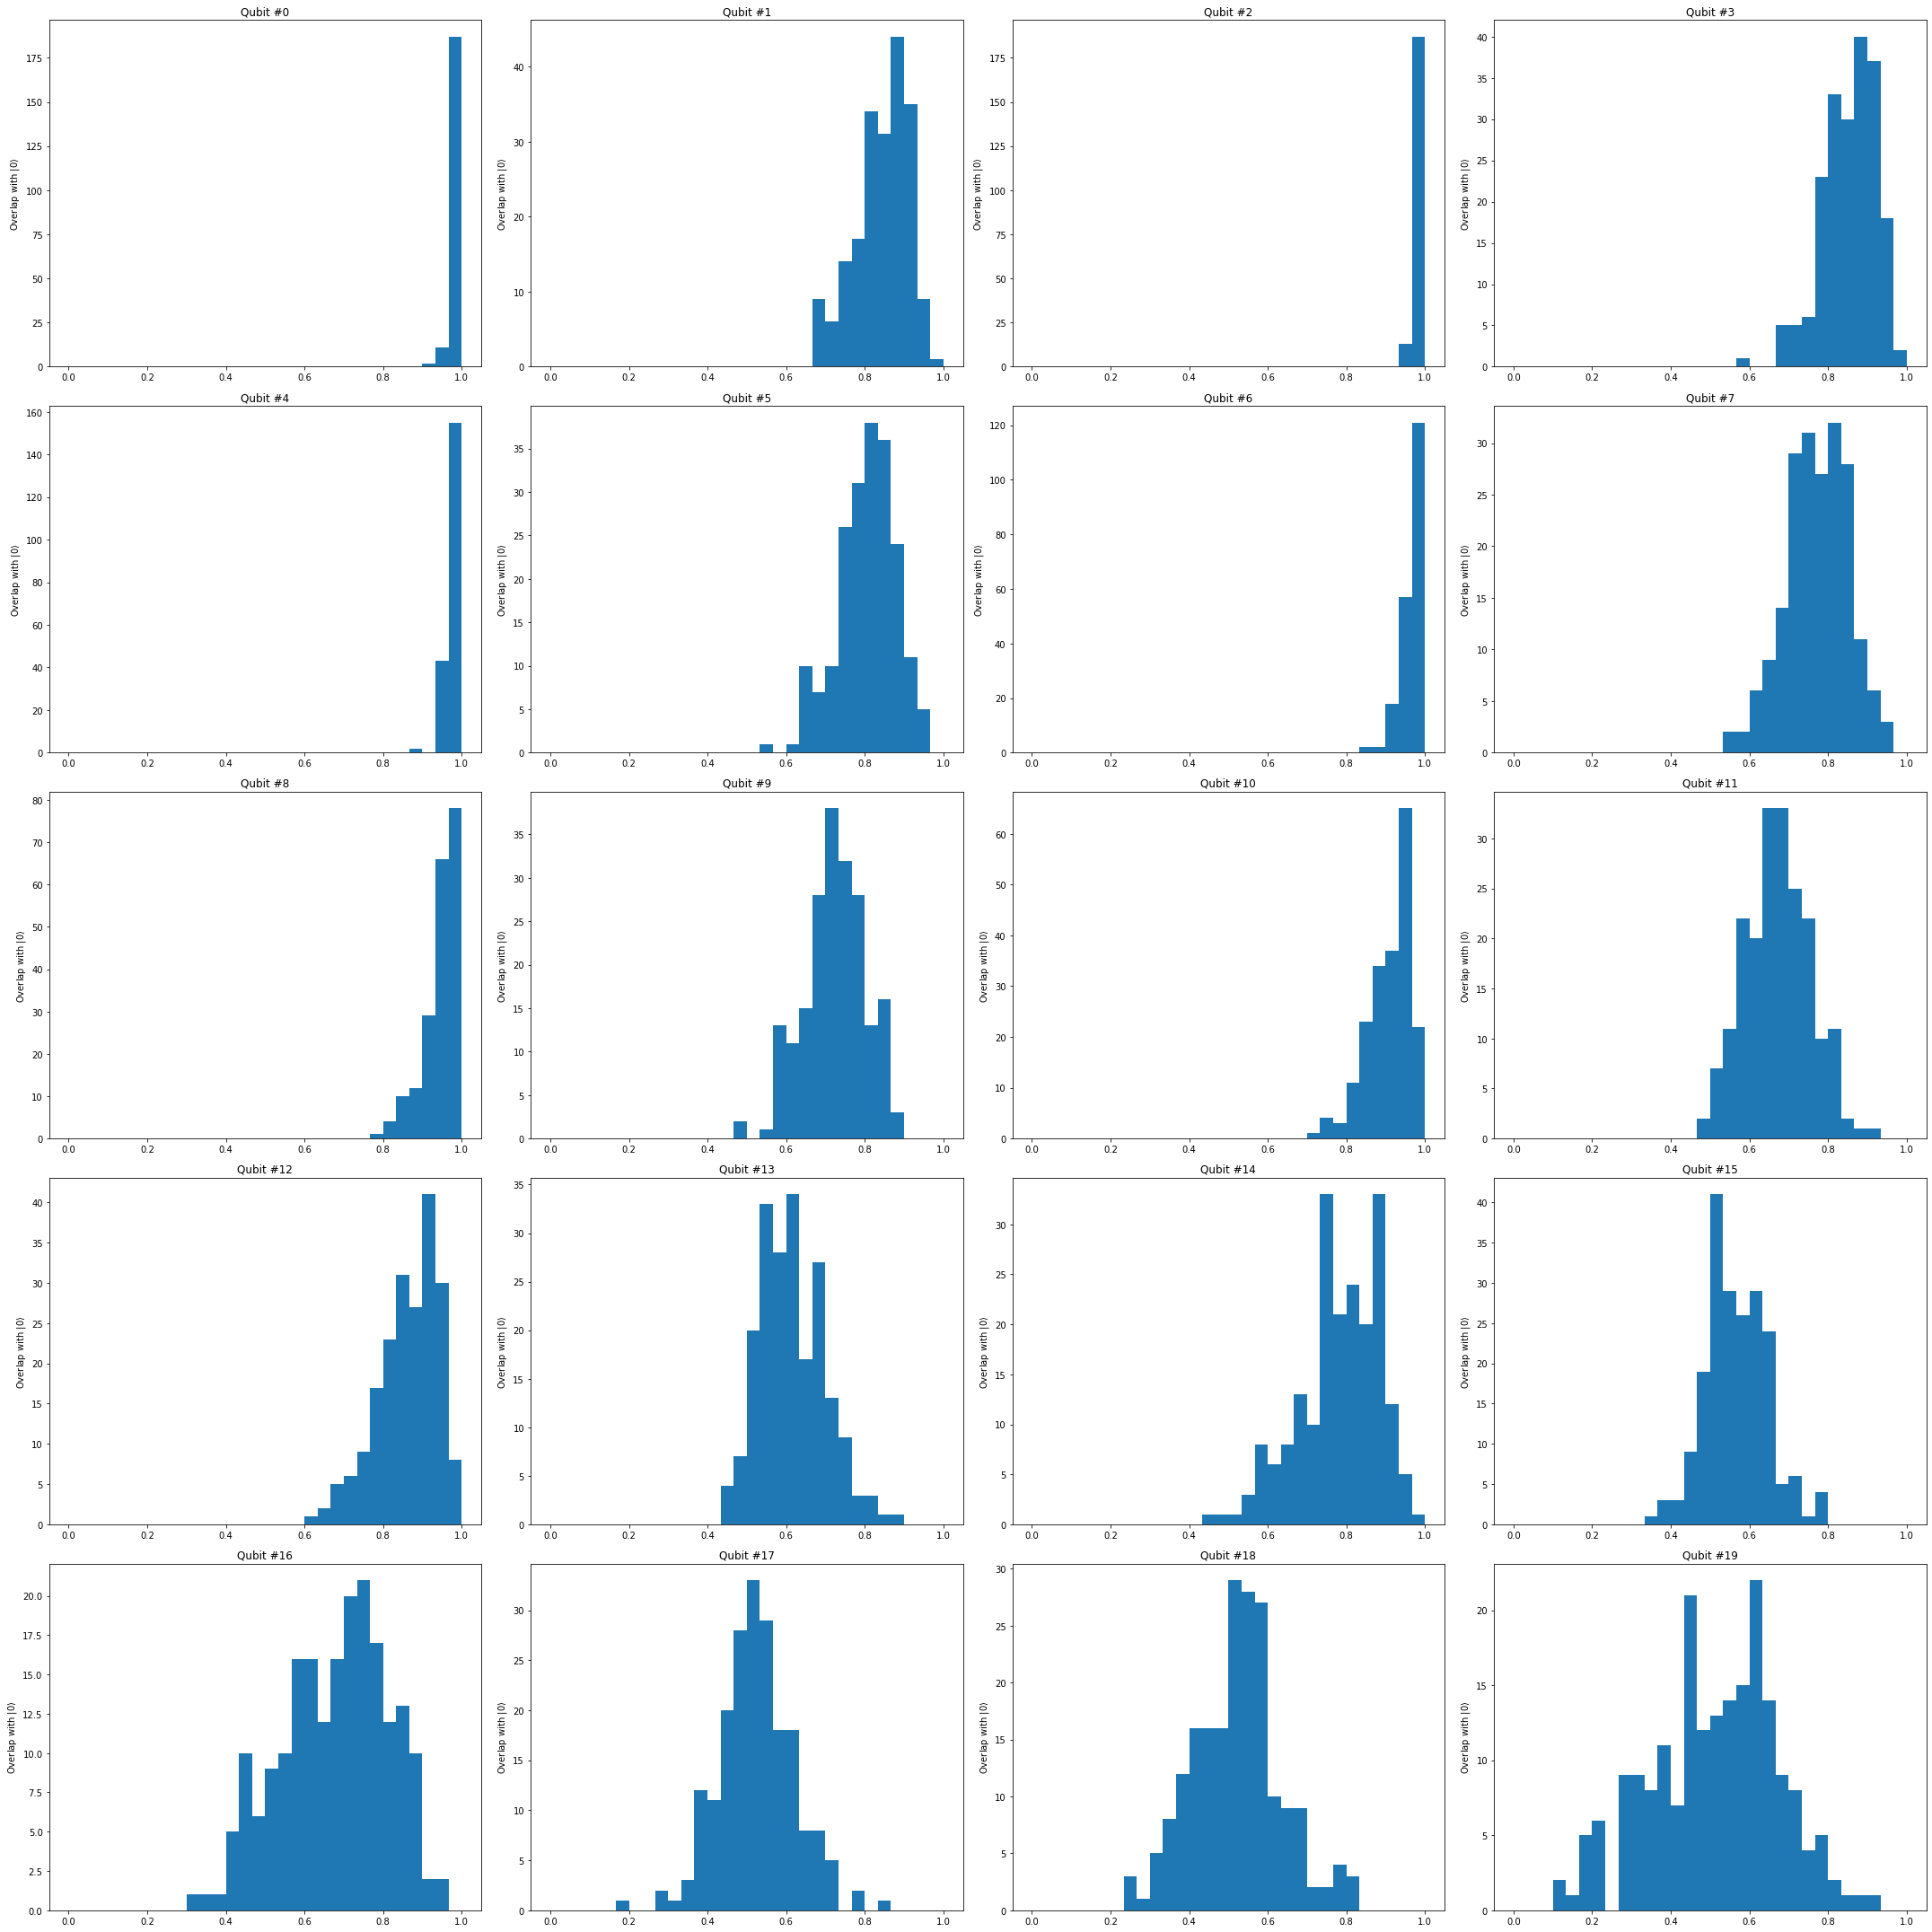

In [28]:
fig=plt.figure(figsize=(30, 30))
t = 0
for i in range(10*2):
    ax=fig.add_subplot(5,4, i+1)
    ax.hist(ps[:, i], bins = 30, range=(0,1))
    ax.set_title(f"Qubit #{i}")
    ax.set_ylabel(r"Overlap with $|0\rangle$")
fig.tight_layout()  # Improves appearance a bit.
# plt.savefig('concurrences_bigger.png')
plt.show()


In [ ]:
ps = []

In [37]:
for x in tqdm(range(len(ps),200)):
    ps.append(cs.sample_better_ladder_faster_probabilities(5,3))
ps = np.array(ps)

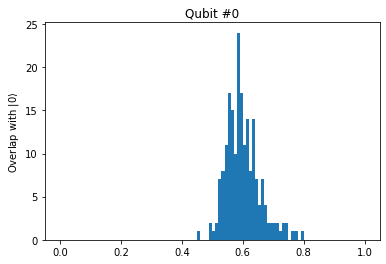

In [40]:
plt.hist(ps[:,0], bins = 100, range=(0,1))
plt.title(f"Qubit #{0}")
plt.ylabel(r"Overlap with $|0\rangle$")
plt.show()

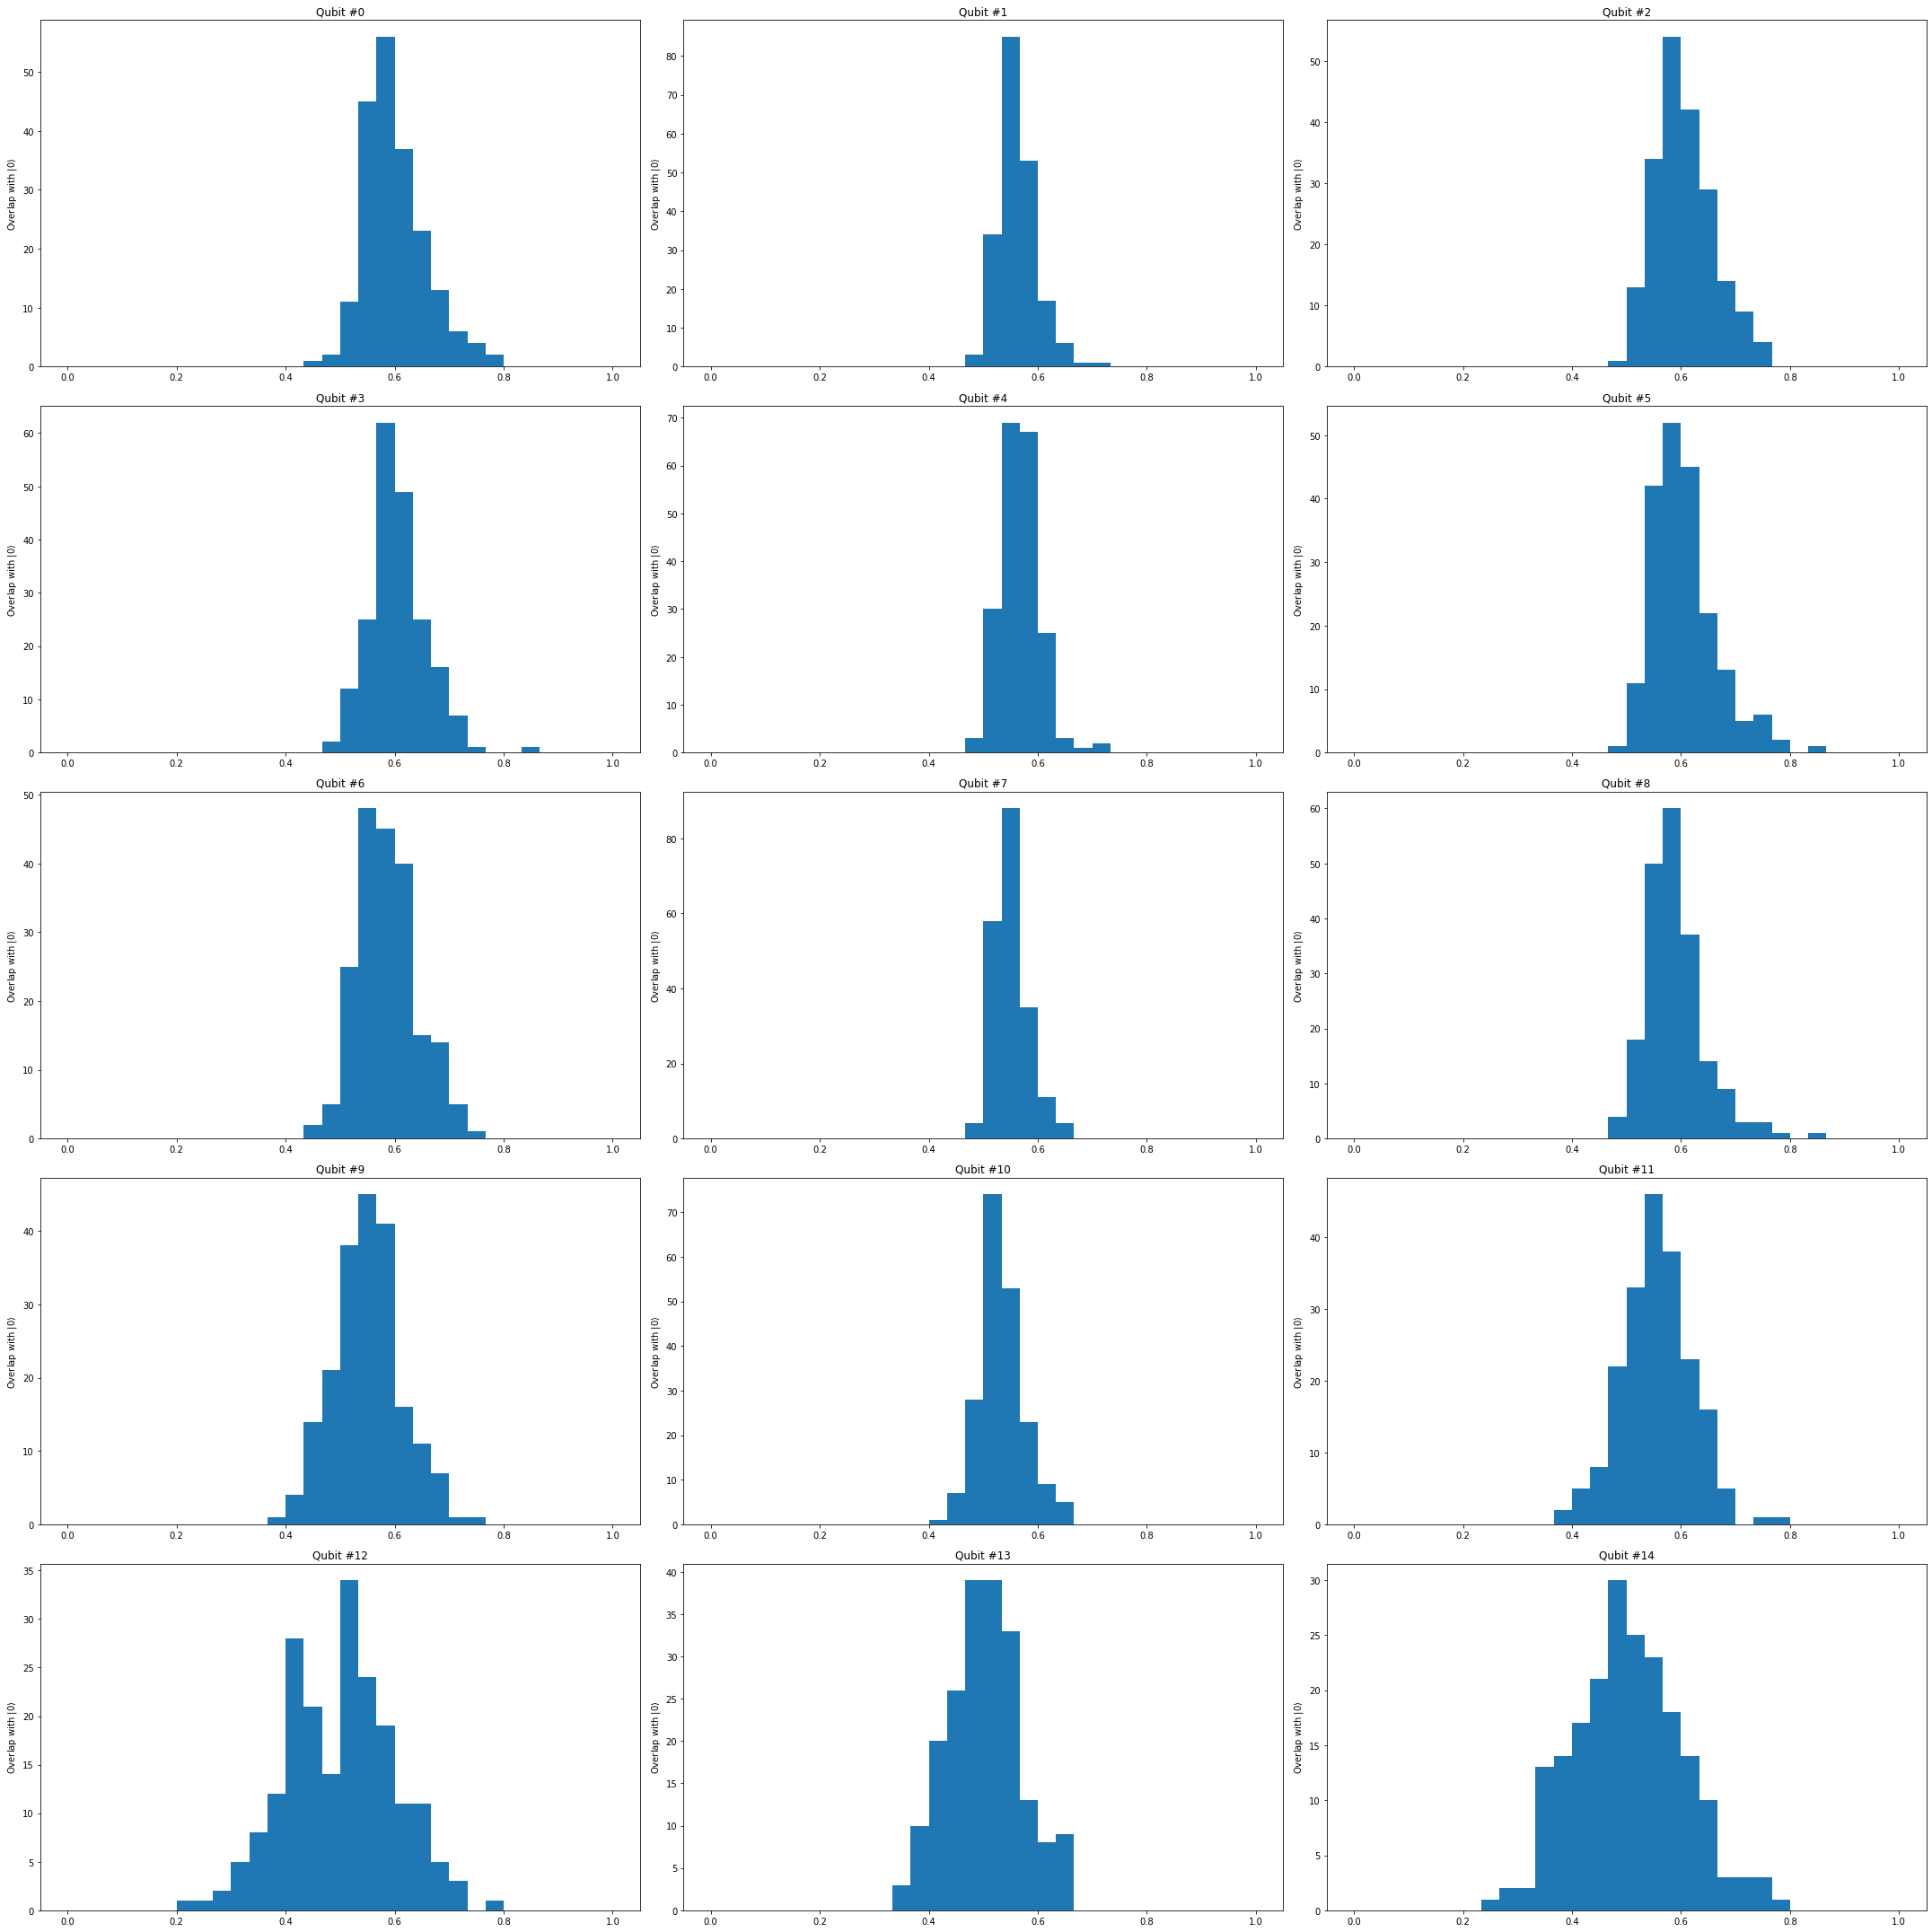

In [41]:
fig=plt.figure(figsize=(30, 30))
t = 0
for i in range(15):
    ax=fig.add_subplot(5,3, i+1)
    ax.hist(ps[:, i], bins = 30, range=(0,1))
    ax.set_title(f"Qubit #{i}")
    ax.set_ylabel(r"Overlap with $|0\rangle$")
fig.tight_layout()  # Improves appearance a bit.
# plt.savefig('concurrences_bigger.png')
plt.show()
